In [17]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error

random_state=0

In [8]:
df= pd.read_csv('auto-mpg.csv')

df = df.drop('carname', axis=1)
df.columns

Index(['mpg', 'cylinders', 'displacement', 'hp', 'weight', 'acc', 'year'], dtype='object')

In [14]:
df.shape

(392, 7)

In [11]:
import xgboost as xgb
# Create an XGBoost regressor
xgb_reg = xgb.XGBRegressor(random_state=0)
scores_xgb = cross_val_score(xgb_reg, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
y_pred_xgb = cross_val_predict(xgb_reg, X_test, y_test)
scores_test_xgb = cross_val_score(xgb_reg, X_test, y_test, scoring='neg_mean_absolute_error', cv=10)
print(np.mean(scores_test_xgb) * -1)


2.141738089833941


/usr/lib/python3/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/lib/python3/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-15-4e51a89cb0ac>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[X_train[col] == v

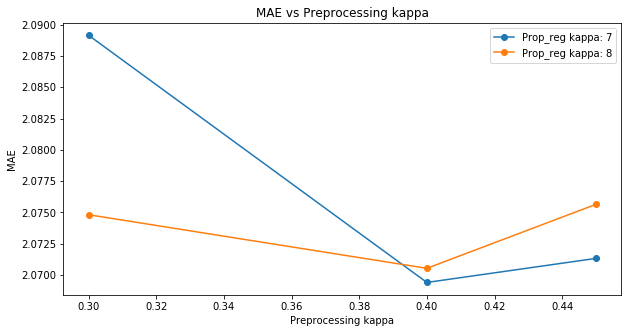

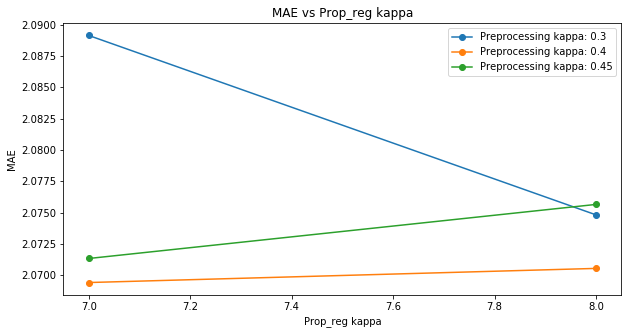

Optimal Preprocessing kappa: 0.4
Optimal Prop_reg kappa: 7
Minimum MAE: 2.0694066925041894


In [15]:
def preprocess_data(X_train, X_test, y_train, kappa, ordinal_columns):
    X_train, X_test = handle_categorical(X_train, X_test, y_train, ordinal_columns)
    X_train, X_test = handle_ordinal(X_train, X_test, y_train, kappa, ordinal_columns)
    return X_train, X_test


def handle_categorical(X_train, X_test, y_train, ordinal_columns):
    means = {}

    for col in X_train.columns:
        if col not in ordinal_columns:  # Categorical variable
            unique_values_train = X_train[col].unique()
            unique_values_test = X_test[col].unique()

            for val in unique_values_train:
                mean = y_train[X_train[col] == val].mean()
                means[(col, val)] = mean
                print(f"Column: {col}, Value: {val}, Mean: {mean}")

            for val in unique_values_test:
                if val not in unique_values_train:
                    print(f"Warning: Value {val} in column {col} of X_test is not in X_train.")

    for col, val in means:
        X_train.loc[X_train[col] == val, col] = means[(col, val)]
        X_test.loc[X_test[col] == val, col] = means[(col, val)]

    return X_train, X_test


def handle_ordinal(X_train, X_test, y_train, kappa, ordinal_columns):
    missing_values = {}

    for col in X_train.columns:
        if col in ordinal_columns:  # Ordinal variable
            unique_values_train = X_train[col].unique()
            unique_values_test = X_test[col].unique()

            for val in unique_values_test:
                y_train_np = y_train.to_numpy()
                X_train_col_np = X_train[[col]].to_numpy()
                X_test_col_val = val
                l = 0
                v = 0
                for j in range(X_train_col_np.shape[0]):
                    d=np.sqrt(np.sum((X_test_col_val - X_train_col_np[j])**2))
                    l += y_train_np[j] / ((1 + d) ** kappa)
                    v += 1 / ((1 + d) ** kappa)
                imputed_value = l / v
                missing_values[(col, val)] = imputed_value

            for val in unique_values_train:
                if val not in unique_values_test:
                    y_train_np = y_train.to_numpy()
                    X_train_col_np = X_train[[col]].to_numpy()
                    X_train_col_val = val
                    l = 0
                    v = 0
                    for j in range(X_train_col_np.shape[0]):
                        d = abs(X_train_col_val - X_train_col_np[j])
                        l += y_train_np[j] / ((1 + d) ** kappa)
                        v += 1 / ((1 + d) ** kappa)
                    imputed_value = l / v
                    missing_values[(col, val)] = imputed_value

    for col, val in missing_values:
        X_train.loc[X_train[col] == val, col] = missing_values[(col, val)]
        X_test.loc[X_test[col] == val, col] = missing_values[(col, val)]

    return X_train, X_test



def prop_reg(X_test,X_train,y_train,y_test,kappa):
    d = np.zeros((len(X_test),len(X_train)))
    for i in range(len(X_test)):
        for j in range(len(X_train)):
            d[i,j] = np.linalg.norm(X_test[i]-X_train[j])
    c=np.zeros(len(y_test))
    for i in range(len(y_test)):
        l=0
        v=0
        for j in range(len(y_train)):
            
            l+=y_train[j]/((1+d[i,j])**kappa)
            v+=1/((1+d[i,j])**kappa)
        
        c[i]=l/v
    return(c)


def kfold_cv(X, y, ordinal_columns, kappa_values_preprocessing, kappa_values_prop_reg, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    results = {}
    mae_values_per_kappa = {}

    for kappa_preprocessing in kappa_values_preprocessing:
        for kappa_prop_reg in kappa_values_prop_reg:
            mae_values = []

            for train_index, test_index in kf.split(X):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                X_train_preprocessed, X_test_preprocessed = preprocess_data(X_train, X_test, y_train, kappa_preprocessing, ordinal_columns)
                y_pred = prop_reg(X_test_preprocessed.values, X_train_preprocessed.values, y_train.values, y_test.values, kappa_prop_reg)
                mae = mean_absolute_error(y_test, y_pred)
                mae_values.append(mae)

            results[(kappa_preprocessing, kappa_prop_reg)] = np.mean(mae_values)
            mae_values_per_kappa[(kappa_preprocessing, kappa_prop_reg)] = mae_values

    return results, mae_values_per_kappa



import matplotlib.pyplot as plt

X = df.iloc[:, 1:]
y = df.iloc[:, 0]

ordinal_columns = ['cylinders', 'displacement', 'hp', 'weight', 'acc', 'year']
kappa_values_preprocessing = [0.3,0.4,0.45]
kappa_values_prop_reg = [7,8]

cv_results, mae_values_per_kappa = kfold_cv(X, y, ordinal_columns, kappa_values_preprocessing, kappa_values_prop_reg)



# Plot the MAE vs kappa curve for preprocessing
plt.figure(figsize=(10, 5))
for kappa_prop_reg in kappa_values_prop_reg:
    mae_values = [np.mean(mae_values_per_kappa[(kappa_preprocessing, kappa_prop_reg)]) for kappa_preprocessing in kappa_values_preprocessing]
    plt.plot(kappa_values_preprocessing, mae_values, '-o', label=f"Prop_reg kappa: {kappa_prop_reg}")

plt.xlabel('Preprocessing kappa')
plt.ylabel('MAE')
plt.title('MAE vs Preprocessing kappa')
plt.legend()
plt.show()

# Plot the MAE vs kappa curve for prop_reg
plt.figure(figsize=(10, 5))
for kappa_preprocessing in kappa_values_preprocessing:
    mae_values = [np.mean(mae_values_per_kappa[(kappa_preprocessing, kappa_prop_reg)]) for kappa_prop_reg in kappa_values_prop_reg]
    plt.plot(kappa_values_prop_reg, mae_values, '-o', label=f"Preprocessing kappa: {kappa_preprocessing}")

plt.xlabel('Prop_reg kappa')
plt.ylabel('MAE')
plt.title('MAE vs Prop_reg kappa')
plt.legend()
plt.show()


    # Find the optimal combination of kappa values
optimal_kappa_preprocessing, optimal_kappa_prop_reg = min(cv_results, key=cv_results.get)
optimal_mae = cv_results[(optimal_kappa_preprocessing, optimal_kappa_prop_reg)]

print(f"Optimal Preprocessing kappa: {optimal_kappa_preprocessing}")
print(f"Optimal Prop_reg kappa: {optimal_kappa_prop_reg}")
print(f"Minimum MAE: {optimal_mae}")


In [16]:
# Print all the combinations of kappa values and their corresponding MAE values
print("Kappa combinations and their MAE values:")
for (kappa_preprocessing, kappa_prop_reg), mae in cv_results.items():
    print(f"Preprocessing kappa: {kappa_preprocessing}, Prop_reg kappa: {kappa_prop_reg}, MAE: {mae}")
    

Kappa combinations and their MAE values:
Preprocessing kappa: 0.3, Prop_reg kappa: 7, MAE: 2.0891484322338654
Preprocessing kappa: 0.3, Prop_reg kappa: 8, MAE: 2.074815312540836
Preprocessing kappa: 0.4, Prop_reg kappa: 7, MAE: 2.0694066925041894
Preprocessing kappa: 0.4, Prop_reg kappa: 8, MAE: 2.0705354335597472
Preprocessing kappa: 0.45, Prop_reg kappa: 7, MAE: 2.0713275161215177
Preprocessing kappa: 0.45, Prop_reg kappa: 8, MAE: 2.0756476995658444


In [18]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.20,random_state=0)

# Random Forest
ranf = RandomForestRegressor(random_state=0)
rf = ranf.fit(X_train, y_train)
scores_rf = cross_val_score(rf, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)

y_pred_rf = cross_val_predict(ranf, X_test, y_test)
scores_test_rf = cross_val_score(ranf, X_test, y_test, scoring='neg_mean_absolute_error', cv=10)
print(np.mean(scores_test_rf) * -1)

# Decision Tree
dectree = DecisionTreeRegressor(random_state=0)
dt = dectree.fit(X_train, y_train)
scores_dt = cross_val_score(dt, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)

y_pred_dt = cross_val_predict(dectree, X_test, y_test)
scores_test_dt = cross_val_score(dectree, X_test, y_test, scoring='neg_mean_absolute_error', cv=10)
print(np.mean(scores_test_dt) * -1)

# K-Nearest Neighbors
knn_model = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)
y_pred_knn = cross_val_predict(knn_model, X_test, y_test)
scores_test_knn = cross_val_score(knn_model, X_test, y_test, scoring='neg_mean_absolute_error', cv=10)
print(np.mean(scores_test_knn) * -1)

# Create an XGBoost regressor
xgb_reg = xgb.XGBRegressor(random_state=0)
scores_xgb = cross_val_score(xgb_reg, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
y_pred_xgb = cross_val_predict(xgb_reg, X_test, y_test)
scores_test_xgb = cross_val_score(xgb_reg, X_test, y_test, scoring='neg_mean_absolute_error', cv=10)
print(np.mean(scores_test_xgb) * -1)

2.04769107142857
2.684107142857143
3.2712142857142856
2.141738089833941
